# CARP

In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [3]:
from scr.encoding.encoding_classes import CARPEncoder

In [4]:
from scr.utils import pickle_load
import pandas as pd

In [5]:
df = pd.read_csv("data/proeng/gb1/two_vs_rest.csv")

In [6]:
df_train = df.loc[(df["set"] == "train") & (df["validation"] != True)]
df_val = df.loc[(df["set"] == "train") & (df["validation"] == True)]
df_test = df.loc[(df["set"] == "test")]

len(df_train), len(df_val), len(df_test), len(df)

(381, 43, 8309, 8733)

In [7]:

seqs = [[seq] for seq in df_val.sequence.astype(str).str[0 : 56].values[0:2]]
seqs

[['MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVNGEWTYDDATKTFTVTE'],
 ['MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEYGEWTYDDATKTFTVTE']]

In [8]:
list(df_val.sequence.astype(str).str[0 : 56].values[0:2])

['MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVNGEWTYDDATKTFTVTE',
 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEYGEWTYDDATKTFTVTE']

In [10]:
# new carp
no_flat_encoder = CARPEncoder(
    encoder_name="carp_600k",
).encode(mut_seqs=list(df_val.sequence.astype(str).str[0 : 56].values[0:2]))
one_emb = next(no_flat_encoder)

Generating carp_600k upto 16 layer embedding ...


In [10]:
one_emb.keys(), one_emb[0].shape

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]),
 (2, 56, 128))

In [11]:
one_emb[0]

array([[[ 0.18291792,  0.14217652,  0.09599978, ...,  0.17569184,
         -0.49006134,  0.1720592 ],
        [ 0.15084319,  0.14380652, -0.05107236, ...,  0.201802  ,
          0.7164676 ,  0.2889837 ],
        [ 0.09628076,  0.251731  ,  0.11050987, ...,  0.21920589,
         -2.5208793 ,  0.48813882],
        ...,
        [ 0.07966915,  0.07801041,  0.08073975, ...,  0.16970871,
         -3.6827595 ,  0.14617534],
        [ 0.12627378,  0.1967569 ,  0.24298412, ...,  0.0919202 ,
          1.3360579 ,  0.54003155],
        [ 0.13612685,  0.24773397,  0.10575762, ...,  0.06591133,
         -1.3406    ,  0.3697617 ]],

       [[ 0.18291792,  0.14217652,  0.09599978, ...,  0.17569184,
         -0.49006134,  0.1720592 ],
        [ 0.15084319,  0.14380652, -0.05107236, ...,  0.201802  ,
          0.7164676 ,  0.2889837 ],
        [ 0.09628076,  0.251731  ,  0.11050987, ...,  0.21920589,
         -2.5208793 ,  0.48813882],
        ...,
        [ 0.07966915,  0.07801041,  0.08073975, ...,  

In [9]:
no_flat_encoder = CARPEncoder(
    encoder_name="carp_600k",
).encode(mut_seqs=list(df_val.sequence.astype(str).str[0 : 56].values[0:2]))
one_emb = next(no_flat_encoder)
one_emb[0], one_emb[0].shape

Generating carp_600k upto 16 layer embedding ...
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening
No embedding flattening


(array([[[ 0.1123378 , -0.03096455,  0.09588866, ..., -0.21515828,
          -0.41078544,  0.8417189 ],
         [ 0.20500934, -0.14373404, -0.15035409, ...,  0.13152508,
          -0.129341  ,  0.50128317],
         [ 0.42361322, -0.09426615,  0.04951379, ...,  0.22084078,
          -3.9057856 ,  0.7927066 ],
         ...,
         [ 0.31486925, -0.00696402,  0.12247566, ..., -0.05261485,
          -4.633561  ,  0.5593644 ],
         [ 0.27489305, -0.01615846,  0.14888935, ..., -0.03519905,
           0.3777458 ,  0.5697537 ],
         [ 0.34990996,  0.2566081 ,  0.21758933, ...,  0.10277106,
          -3.0541043 ,  0.3111604 ]],
 
        [[ 0.1123378 , -0.03096455,  0.09588866, ..., -0.21515828,
          -0.41078544,  0.8417189 ],
         [ 0.20500934, -0.14373404, -0.15035409, ...,  0.13152508,
          -0.129341  ,  0.50128317],
         [ 0.42361322, -0.09426615,  0.04951379, ...,  0.22084078,
          -3.9057856 ,  0.7927066 ],
         ...,
         [ 0.31486925, -0.0069640

In [9]:
mean_flat_encoder = CARPEncoder(
    encoder_name="carp_600k",
).encode(mut_seqs=list(df_val.sequence.astype(str).str[0 : 56].values[0:2]),flatten_emb="mean")
one_mean_emb = next(mean_flat_encoder)
one_mean_emb[0].shape

Generating carp_600k upto 16 layer embedding ...


(2, 128)

In [13]:
one_mean_emb

{0: array([[[ 0.18291792,  0.14217652,  0.09599978, ...,  0.17569184,
          -0.49006134,  0.1720592 ],
         [ 0.15084319,  0.14380652, -0.05107236, ...,  0.201802  ,
           0.7164676 ,  0.2889837 ],
         [ 0.09628076,  0.251731  ,  0.11050987, ...,  0.21920589,
          -2.5208793 ,  0.48813882],
         ...,
         [ 0.07966915,  0.07801041,  0.08073975, ...,  0.16970871,
          -3.6827595 ,  0.14617534],
         [ 0.12627378,  0.1967569 ,  0.24298412, ...,  0.0919202 ,
           1.3360579 ,  0.54003155],
         [ 0.13612685,  0.24773397,  0.10575762, ...,  0.06591133,
          -1.3406    ,  0.3697617 ]],
 
        [[ 0.18291792,  0.14217652,  0.09599978, ...,  0.17569184,
          -0.49006134,  0.1720592 ],
         [ 0.15084319,  0.14380652, -0.05107236, ...,  0.201802  ,
           0.7164676 ,  0.2889837 ],
         [ 0.09628076,  0.251731  ,  0.11050987, ...,  0.21920589,
          -2.5208793 ,  0.48813882],
         ...,
         [ 0.07966915,  0.0780

In [11]:
from sequence_models.pretrained import load_model_and_alphabet

model, collater = load_model_and_alphabet('carp_600k')

x = collater(seqs)[0]  # (n, max_len)
# rep = model(x)  # (n, max_len, d_model)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.model.embedder.layers[0].register_forward_hook(get_activation("layer0"))

rep = model(x)

activation["layer0"], activation["layer0"].shape

(tensor([[[ 0.1123, -0.0310,  0.0959,  ..., -0.2152, -0.4108,  0.8417],
          [ 0.2050, -0.1437, -0.1504,  ...,  0.1315, -0.1293,  0.5013],
          [ 0.4236, -0.0943,  0.0495,  ...,  0.2208, -3.9058,  0.7927],
          ...,
          [ 0.3149, -0.0070,  0.1225,  ..., -0.0526, -4.6336,  0.5594],
          [ 0.2749, -0.0162,  0.1489,  ..., -0.0352,  0.3777,  0.5698],
          [ 0.3499,  0.2566,  0.2176,  ...,  0.1028, -3.0541,  0.3112]],
 
         [[ 0.1123, -0.0310,  0.0959,  ..., -0.2152, -0.4108,  0.8417],
          [ 0.2050, -0.1437, -0.1504,  ...,  0.1315, -0.1293,  0.5013],
          [ 0.4236, -0.0943,  0.0495,  ...,  0.2208, -3.9058,  0.7927],
          ...,
          [ 0.3149, -0.0070,  0.1225,  ..., -0.0526, -4.6336,  0.5594],
          [ 0.2749, -0.0162,  0.1489,  ..., -0.0352,  0.3777,  0.5698],
          [ 0.3499,  0.2566,  0.2176,  ...,  0.1028, -3.0541,  0.3112]]]),
 torch.Size([2, 56, 128]))

In [12]:
rep = model(x, repr_layers=[0, 1, 2])
# rep = model(x, repr_layers=[0, 2, 32], logits=True)
rep.keys(), rep["representations"].keys(), rep[0], rep["representations"][1]

(dict_keys(['representations', 0]),
 dict_keys([1, 2]),
 tensor([[[ 0.1829,  0.1422,  0.0960,  ...,  0.1757, -0.4901,  0.1721],
          [ 0.1508,  0.1438, -0.0511,  ...,  0.2018,  0.7165,  0.2890],
          [ 0.0963,  0.2517,  0.1105,  ...,  0.2192, -2.5209,  0.4881],
          ...,
          [ 0.0797,  0.0780,  0.0807,  ...,  0.1697, -3.6828,  0.1462],
          [ 0.1263,  0.1968,  0.2430,  ...,  0.0919,  1.3361,  0.5400],
          [ 0.1361,  0.2477,  0.1058,  ...,  0.0659, -1.3406,  0.3698]],
 
         [[ 0.1829,  0.1422,  0.0960,  ...,  0.1757, -0.4901,  0.1721],
          [ 0.1508,  0.1438, -0.0511,  ...,  0.2018,  0.7165,  0.2890],
          [ 0.0963,  0.2517,  0.1105,  ...,  0.2192, -2.5209,  0.4881],
          ...,
          [ 0.0797,  0.0780,  0.0807,  ...,  0.1697, -3.6828,  0.1462],
          [ 0.1263,  0.1968,  0.2430,  ...,  0.0919,  1.3361,  0.5400],
          [ 0.1361,  0.2477,  0.1058,  ...,  0.0659, -1.3406,  0.3698]]],
        grad_fn=<TransposeBackward0>),
 tenso

In [16]:
from sequence_models.pretrained import load_model_and_alphabet

model, collater = load_model_and_alphabet('carp_600k')
max_emb_layer = 32
seqs = [['MDREQ'], ['MGTRXXLP']]
x = collater(seqs)[0]  # (n, max_len)
# rep = model(x)  # (n, max_len, d_model)
rep = model(x, repr_layers=list(range(max_emb_layer + 1)))

In [18]:
rep.keys(), rep["representations"].keys()

(dict_keys(['representations', 0]),
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]))

In [12]:
import copy

In [ ]:
"""
if isinstance(m, nn.Conv2d):
    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)) 
    if m.bias is not None:
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(m.bias, -bound, bound)        
if isinstance(m, nn.Linear):
    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)) 
    if m.bias is not None:
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        torch.nn.init.uniform_(m.bias, -bound, bound)   
"""

In [9]:
import torch
from torch.nn import Parameter  
from torch.nn.init import xavier_uniform_, xavier_normal_, kaiming_uniform_, uniform_, normal_, constant_, _calculate_fan_in_and_fan_out, ones_, zeros_

In [10]:
import math
import torch

def cal_bound(model: torch.nn.Module, layer_name: str):
    """Return bound for reinit given model and layer name"""
    assert "bias" in layer_name, f"no bias in {layer_name}"
    fan_in, _ = _calculate_fan_in_and_fan_out(model.state_dict()[layer_name.replace("bias", "weight")])
    return 1 / math.sqrt(fan_in) if fan_in > 0 else 0


In [47]:
import copy
import numpy as np

def reset_parameters(model):
    """Initiate parameters in the transformer model."""

    for layer_name, p in model.state_dict().items():
        print(f"{layer_name}: {p.shape}")
        if "layers" in layer_name:
            if "conv" in layer_name:
                if "weight" in layer_name:
                    kaiming_uniform_(p, a=math.sqrt(5))
                elif "bias" in layer_name:
                    fan_in, _ = _calculate_fan_in_and_fan_out(model.state_dict()[layer_name.replace("bias", "weight")])
                    if fan_in != 0:
                        bound = 1 / math.sqrt(fan_in)
                        uniform_(p, -bound, bound)
                                
            else:
                if "weight" in layer_name:
                    ones_(p)
                elif "bias" in layer_name:
                    zeros_(p)
                

    return model

def resample_parameters(model, embed_dim):
    
    resample_state = model.state_dict()
    
    for layer_name, p in model.state_dict().items():
        # completely shuffle all weight matrix entries 
        if "layers" in layer_name:
            resample_state[layer_name] = p.view(-1)[torch.randperm(p.view(-1).shape[0])].view(p.shape)

            
    """for layer_name, p in model.state_dict().items(): 
        
        if ("embed_tokens" not in layer_name) and ("embed_out" not in layer_name) and ("_float_tensor" not in layer_name):
            print(f"{layer_name}: {p.shape}")
            
            if len(p.shape) == 1:
                resample_state[layer_name] = p[torch.randperm(p.shape[0])]
                
                layers.n.self_attn.k_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn.v_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn.q_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn.out_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn_layer_norm.weight: torch.Size([embed_dim])
                layers.n.self_attn_layer_norm.bias: torch.Size([embed_dim])
                layers.n.fc1.bias: torch.Size([fc_dim])
                layers.n.fc2.bias: torch.Size([embed_dim])
                layers.n.final_layer_norm.weight: torch.Size([embed_dim])
                layers.n.final_layer_norm.bias: torch.Size([embed_dim])
                
            elif 1 in p.shape:
       
                if "bias_" in layer_name:
                    resample_state[layer_name] = p[:, :, torch.randperm(embed_dim)]
                elif "regression.weight" in layer_name:
                    resample_state[layer_name] = p[:, torch.randperm(p.shape[-1])]
            
            elif "k_proj.weight" or "q_proj.weight" or "fc1.weight" in layer_name:
                resample_state[layer_name] = p[torch.randperm(p.shape[0]),:]
         
            elif "v_proj.weight" or "out_proj.weight" or "fc2.weight" in layer_name:
         
                resample_state[layer_name] = p[:, torch.randperm(p.shape[1])]"""
               
    model.load_state_dict(resample_state)

    return model

In [13]:
t = torch.rand(3,3,2)
t

tensor([[[0.7539, 0.1952],
         [0.0050, 0.3068],
         [0.1165, 0.9103]],

        [[0.6440, 0.7071],
         [0.6581, 0.4913],
         [0.8913, 0.1447]],

        [[0.5315, 0.1587],
         [0.6542, 0.3278],
         [0.6532, 0.3958]]])

In [18]:
r=torch.randperm(t.shape[0])
c=torch.randperm(t.shape[1])
t_shuf=t[r[:, None], c]
t_shuf

tensor([[[0.0050, 0.3068],
         [0.1165, 0.9103],
         [0.7539, 0.1952]],

        [[0.6581, 0.4913],
         [0.8913, 0.1447],
         [0.6440, 0.7071]],

        [[0.6542, 0.3278],
         [0.6532, 0.3958],
         [0.5315, 0.1587]]])

In [23]:
r, r[:, None], c

(tensor([0, 1, 2]),
 tensor([[0],
         [1],
         [2]]),
 tensor([1, 2, 0]))

In [19]:
# With view
idx = torch.randperm(t_shuf.nelement())
idx

tensor([17,  5, 10, 16,  4,  9,  1, 11,  3, 14,  8, 12,  6,  2, 13,  0, 15,  7])

In [24]:
t_shuf.view(-1)[idx].view(t_shuf.size())

tensor([[[0.1587, 0.1952],
         [0.6440, 0.5315],
         [0.7539, 0.1447]],

        [[0.3068, 0.7071],
         [0.9103, 0.6532],
         [0.8913, 0.6542]],

        [[0.6581, 0.1165],
         [0.3278, 0.0050],
         [0.3958, 0.4913]]])

In [20]:
t = t.view(-1)[idx].view(t.size())
t

tensor([[[0.3958, 0.9103],
         [0.8913, 0.6532],
         [0.1165, 0.4913]],

        [[0.1952, 0.1447],
         [0.3068, 0.6542],
         [0.6581, 0.5315]],

        [[0.6440, 0.0050],
         [0.1587, 0.7539],
         [0.3278, 0.7071]]])

In [31]:
t

tensor([[[0.3958, 0.9103],
         [0.8913, 0.6532],
         [0.1165, 0.4913]],

        [[0.1952, 0.1447],
         [0.3068, 0.6542],
         [0.6581, 0.5315]],

        [[0.6440, 0.0050],
         [0.1587, 0.7539],
         [0.3278, 0.7071]]])

In [39]:
t2 = torch.rand(3,2)
t2

tensor([[0.2938, 0.3516],
        [0.8158, 0.3293],
        [0.1113, 0.1445]])

In [40]:
t2.view(-1)[torch.randperm(t2.view(-1).shape[0])].view(t2.shape)

tensor([[0.1113, 0.3293],
        [0.2938, 0.1445],
        [0.3516, 0.8158]])

In [41]:
t1 = torch.rand(3)
t1

tensor([0.0643, 0.8377, 0.7625])

In [42]:
t1.view(-1)[torch.randperm(t1.view(-1).shape[0])].view(t1.shape)

tensor([0.0643, 0.7625, 0.8377])

In [36]:
t.view(-1)[torch.randperm(t.view(-1).shape[0])].view(t.shape)

tensor([[[0.5315, 0.6581],
         [0.3068, 0.1587],
         [0.1165, 0.6532]],

        [[0.7071, 0.7539],
         [0.3278, 0.0050],
         [0.6440, 0.6542]],

        [[0.1952, 0.9103],
         [0.3958, 0.4913],
         [0.1447, 0.8913]]])

In [ ]:
torch.rand(2,3)

In [25]:
def shuffle_2D(t):
    r=torch.randperm(t.shape[0])
    c=torch.randperm(t.shape[1])
    t=t[r[:, None], c]

    # With view
    idx = torch.randperm(t.nelement())
    return t.view(-1)[idx].view(t.size())


In [29]:
t_3d = torch.rand(4,3,2)
t_3d, t_3d.shape

(tensor([[[0.9037, 0.9555],
          [0.1035, 0.6258],
          [0.2849, 0.4452]],
 
         [[0.1258, 0.9554],
          [0.1330, 0.7672],
          [0.6757, 0.6625]],
 
         [[0.2297, 0.9545],
          [0.6099, 0.5643],
          [0.0594, 0.7099]],
 
         [[0.4250, 0.2709],
          [0.9295, 0.6115],
          [0.2234, 0.2469]]]),
 torch.Size([4, 3, 2]))

In [ ]:
t_

In [30]:
from sequence_models.pretrained import load_model_and_alphabet


og_model, og_collater = load_model_and_alphabet('carp_600k')
seqs = [['MDREQ'], ['MGTRXXLP']]
x = og_collater(seqs)[0]  # (n, max_len)
# rep = model(x)  # (n, max_len, d_model)
og_rep = og_model(x)

In [ ]:
model = copy.deepcopy(og_model)
model = reset_parameters(model)
# model = resample_parameters(model, encoder_name, 768)

reset_reps = model(x)

In [45]:
import matplotlib.pyplot as plt

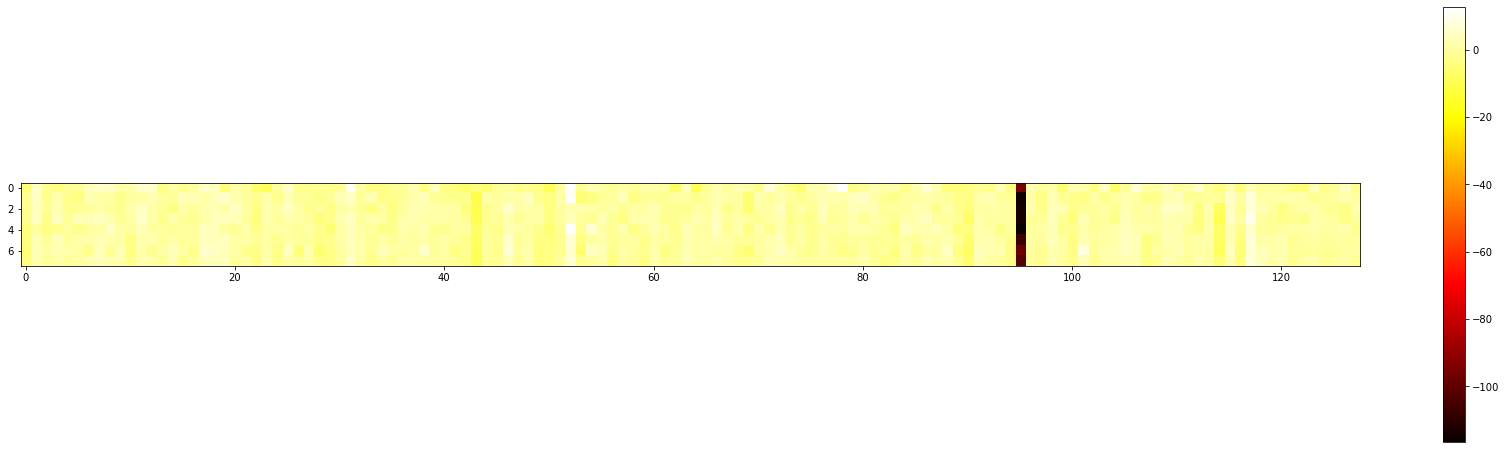

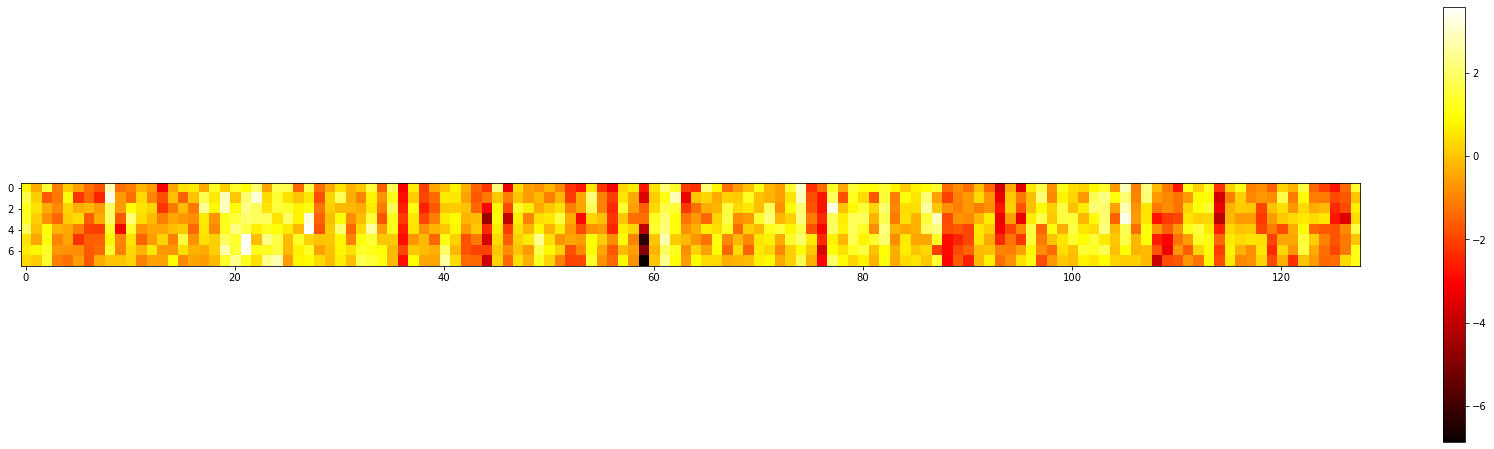

In [49]:
plt.figure(figsize=(30,8))
plt.imshow(og_rep["representations"][16].detach().numpy().mean(0), cmap="hot", interpolation='nearest')
plt.colorbar()
plt.figure(figsize=(30,8))
plt.imshow(reset_reps["representations"][16].detach().numpy().mean(0), cmap="hot", interpolation='nearest')
plt.colorbar()

In [48]:
model = copy.deepcopy(og_model)
# model = reset_parameters(model)
model = resample_parameters(model, 768)

reset_reps = model(x)

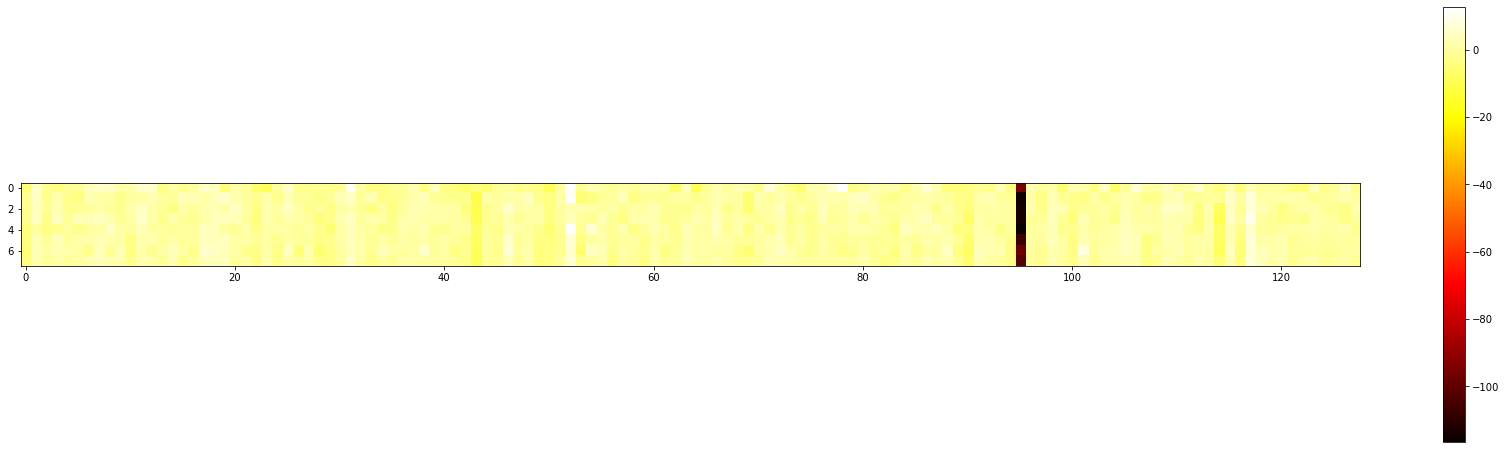

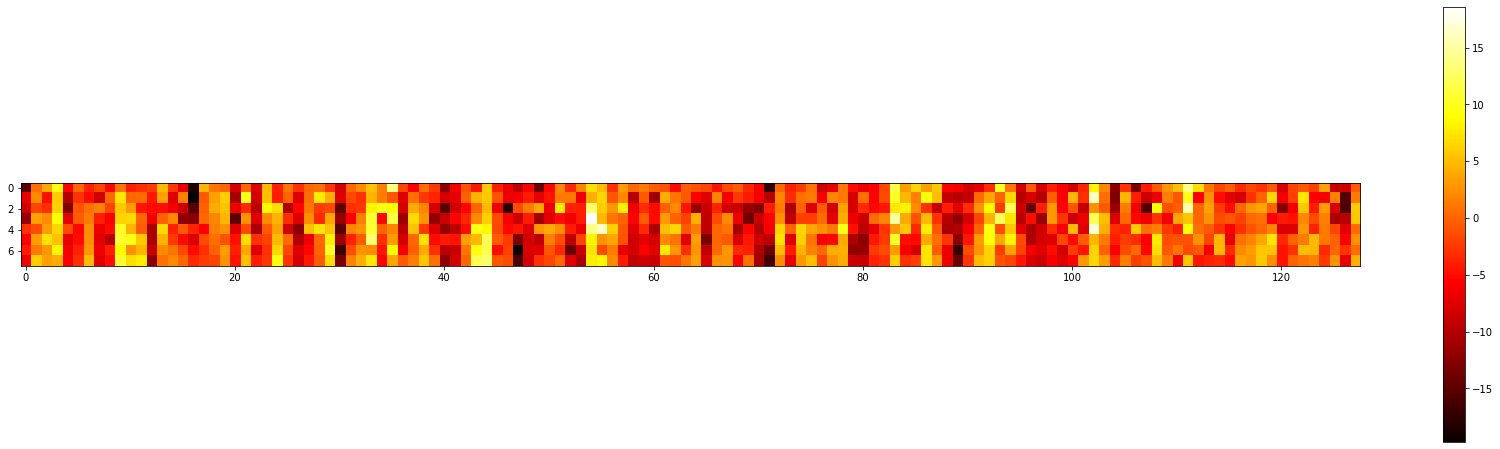

In [49]:
plt.figure(figsize=(30,8))
plt.imshow(og_rep["representations"][16].detach().numpy().mean(0), cmap="hot", interpolation='nearest')
plt.colorbar()
plt.figure(figsize=(30,8))
plt.imshow(reset_reps["representations"][16].detach().numpy().mean(0), cmap="hot", interpolation='nearest')
plt.colorbar()

In [52]:
og_model.state_dict()["model.embedder.layers.0.conv.weight"]

tensor([[[-1.1865e-01, -1.7188e-01,  2.7145e-02,  7.9956e-02,  2.8778e-02],
         [-1.3098e-01, -6.7078e-02,  6.2164e-02,  6.2683e-02, -3.7109e-02],
         [-1.0760e-01,  5.3101e-02, -7.4707e-02, -5.9204e-02,  1.0358e-01],
         ...,
         [-2.6276e-02, -2.5000e-01,  5.3314e-02, -1.0858e-01, -1.1795e-02],
         [-1.3281e-01, -1.0852e-01,  1.4001e-01,  5.6915e-02,  9.3140e-02],
         [-1.4233e-01, -3.0664e-01,  9.9060e-02,  2.1191e-01,  9.8267e-02]],

        [[-1.7810e-01, -1.8042e-01,  1.2964e-01, -8.5388e-02, -1.7838e-02],
         [-9.3079e-02,  2.2430e-02, -6.6162e-02,  9.4788e-02, -6.7383e-02],
         [ 4.6112e-02,  1.7181e-02, -1.2201e-01,  2.8351e-02,  7.5073e-02],
         ...,
         [-4.2206e-02,  1.2250e-01,  1.4473e-02, -1.1365e-01, -3.6926e-02],
         [ 6.6345e-02,  5.9845e-02,  5.4321e-02, -1.3965e-01,  6.2037e-04],
         [-2.1011e-02, -6.0883e-02,  4.7852e-02, -6.6260e-01, -1.0352e-01]],

        [[ 5.5298e-02,  4.7333e-02, -5.7343e-02, -8.4473

In [53]:
model.state_dict()["model.embedder.layers.0.conv.weight"]

tensor([[[-6.0699e-02, -6.1328e-01,  9.5520e-02, -1.0431e-01,  5.2246e-02],
         [ 1.2189e-01,  2.9984e-02,  5.9540e-02,  1.6101e-01,  1.1133e-01],
         [ 1.6650e-01,  2.4207e-01,  6.2378e-02,  8.4076e-03, -1.0315e-01],
         ...,
         [ 4.5654e-01, -6.1493e-02, -9.6252e-02,  3.9886e-02, -1.4572e-02],
         [ 1.5295e-01, -5.2460e-02,  1.0272e-01, -3.8757e-02, -3.3752e-02],
         [-1.8506e-01,  1.7175e-01,  2.3514e-02, -3.5278e-02, -8.3862e-02]],

        [[-6.8262e-01, -7.9590e-02, -1.4290e-02, -3.0777e-02,  8.4595e-02],
         [-1.0864e-01,  1.5430e-01, -5.4291e-02, -5.8044e-02, -5.4297e-01],
         [-1.9519e-01, -1.6028e-01, -6.5735e-02, -1.3745e-01,  8.3069e-02],
         ...,
         [-1.8018e-01, -2.1838e-01,  9.5032e-02,  1.7322e-01,  5.1025e-02],
         [ 9.9060e-02, -3.5254e-01, -2.7075e-01, -1.3892e-01, -3.5986e-01],
         [ 6.3293e-02, -1.3989e-01, -1.2927e-01, -3.8818e-02,  1.3647e-01]],

        [[-2.1088e-02, -3.5187e-02, -1.5308e-01, -7.5317

In [56]:
sorted(og_model.state_dict()["model.embedder.layers.0.conv.weight"].unique())

[tensor(-2.4668),
 tensor(-2.2910),
 tensor(-2.0938),
 tensor(-2.0195),
 tensor(-2.0020),
 tensor(-1.9971),
 tensor(-1.9961),
 tensor(-1.9678),
 tensor(-1.9473),
 tensor(-1.9219),
 tensor(-1.9111),
 tensor(-1.8438),
 tensor(-1.8174),
 tensor(-1.7529),
 tensor(-1.6934),
 tensor(-1.6465),
 tensor(-1.6455),
 tensor(-1.6426),
 tensor(-1.6396),
 tensor(-1.6094),
 tensor(-1.6025),
 tensor(-1.5732),
 tensor(-1.5654),
 tensor(-1.5576),
 tensor(-1.5527),
 tensor(-1.5508),
 tensor(-1.5352),
 tensor(-1.5254),
 tensor(-1.5215),
 tensor(-1.5176),
 tensor(-1.5107),
 tensor(-1.5088),
 tensor(-1.5039),
 tensor(-1.5010),
 tensor(-1.4990),
 tensor(-1.4961),
 tensor(-1.4902),
 tensor(-1.4883),
 tensor(-1.4795),
 tensor(-1.4717),
 tensor(-1.4707),
 tensor(-1.4639),
 tensor(-1.4570),
 tensor(-1.4561),
 tensor(-1.4512),
 tensor(-1.4502),
 tensor(-1.4473),
 tensor(-1.4160),
 tensor(-1.3984),
 tensor(-1.3916),
 tensor(-1.3857),
 tensor(-1.3750),
 tensor(-1.3682),
 tensor(-1.3652),
 tensor(-1.3623),
 tensor(-1

In [57]:
sorted(model.state_dict()["model.embedder.layers.0.conv.weight"].unique())

[tensor(-2.4668),
 tensor(-2.2910),
 tensor(-2.0938),
 tensor(-2.0195),
 tensor(-2.0020),
 tensor(-1.9971),
 tensor(-1.9961),
 tensor(-1.9678),
 tensor(-1.9473),
 tensor(-1.9219),
 tensor(-1.9111),
 tensor(-1.8438),
 tensor(-1.8174),
 tensor(-1.7529),
 tensor(-1.6934),
 tensor(-1.6465),
 tensor(-1.6455),
 tensor(-1.6426),
 tensor(-1.6396),
 tensor(-1.6094),
 tensor(-1.6025),
 tensor(-1.5732),
 tensor(-1.5654),
 tensor(-1.5576),
 tensor(-1.5527),
 tensor(-1.5508),
 tensor(-1.5352),
 tensor(-1.5254),
 tensor(-1.5215),
 tensor(-1.5176),
 tensor(-1.5107),
 tensor(-1.5088),
 tensor(-1.5039),
 tensor(-1.5010),
 tensor(-1.4990),
 tensor(-1.4961),
 tensor(-1.4902),
 tensor(-1.4883),
 tensor(-1.4795),
 tensor(-1.4717),
 tensor(-1.4707),
 tensor(-1.4639),
 tensor(-1.4570),
 tensor(-1.4561),
 tensor(-1.4512),
 tensor(-1.4502),
 tensor(-1.4473),
 tensor(-1.4160),
 tensor(-1.3984),
 tensor(-1.3916),
 tensor(-1.3857),
 tensor(-1.3750),
 tensor(-1.3682),
 tensor(-1.3652),
 tensor(-1.3623),
 tensor(-1

In [61]:
np.all(sorted(og_model.state_dict()["model.embedder.layers.0.conv.weight"].unique()) == sorted(model.state_dict()["model.embedder.layers.0.conv.weight"].unique()))

True